In [3]:
import json
import os
import warnings
from datetime import datetime
from shutil import copyfile

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pandas_profiling as pp
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv
from category_encoders import TargetEncoder, WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.model_selection import (
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from tqdm import tqdm

np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})  # `easy numbers` mode
pd.set_option("display.max_columns", None)                                # `show whole df` mode
warnings.filterwarnings("ignore")                                         # `do not disturbe` mode

ModuleNotFoundError: No module named 'catboost'

### Load data

In [4]:
df = pd.read_csv("Data\\german_data.csv", sep=",", na_values="NULL")

X = df.drop(
    [
        "GOOD",
        "BAD",
        "duration",
        "credit_his",
        "amount",
        "installment_rate",
    ],
    axis=1,
)
X = pd.get_dummies(X)
y = df["GOOD"]

dtrain = xgb.DMatrix(X, label=y)

X

,present_resid,age,n_credits,n_people,chk_acct_A11,chk_acct_A12,chk_acct_A13,chk_acct_A14,purpose_A40,purpose_A41,purpose_A410,purpose_A42,purpose_A43,purpose_A44,purpose_A45,purpose_A46,purpose_A48,purpose_A49,saving_acct_A61,saving_acct_A62,saving_acct_A63,saving_acct_A64,saving_acct_A65,present_emp_A71,present_emp_A72,present_emp_A73,present_emp_A74,present_emp_A75,sex_A91,sex_A92,sex_A93,sex_A94,other_debtor_A101,other_debtor_A102,other_debtor_A103,property_A121,property_A122,property_A123,property_A124,other_install_A141,other_install_A142,other_install_A143,housing_A151,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreign_A201,foreign_A202
0,4,67,2,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0
1,2,22,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0
2,3,49,1,2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0
3,4,45,1,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0
4,4,53,2,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,31,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0
996,4,40,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0
997,4,38,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0
998,4,23,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0


### Initial fit

In [5]:
MAX_ROUNDS = 1000
CV_SPLITS = 10
EARLY_STOPPING_ROUNDS = 50
SEED = 42

auc_monit = 0.5


def objective(trial, build_name):
    global auc_monit

    param = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-8, 1),
        "max_depth": trial.suggest_int("max_depth", 2, 14),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 50),
        "gamma": trial.suggest_uniform("gamma", 0, 10),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0, 10),
        "subsample": trial.suggest_uniform("subsample", 0.3, 0.9),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.3, 0.9),
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.3, 0.9),
        "colsample_bynode": trial.suggest_uniform("colsample_bynode", 0.3, 0.9),
        "max_delta_step": trial.suggest_int("max_delta_step", 1, 10),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 8)
    }

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-auc")
    xgb_cv_results = xgb.cv(
        params=param,
        dtrain=dtrain,
        stratified=True,
        nfold=CV_SPLITS,
        num_boost_round=MAX_ROUNDS,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose_eval=False,
        seed=SEED,
        callbacks=[pruning_callback],
    )

    n_estimators = len(xgb_cv_results)
    param["n_estimators"] = n_estimators
    trial.set_user_attr("n_estimators", n_estimators)

    mean_train_auc = xgb_cv_results["train-auc-mean"].values[-1]
    mean_val_auc = xgb_cv_results["test-auc-mean"].values[-1]

    if mean_val_auc > auc_monit:
        auc_monit = mean_val_auc

        timestamp = datetime.now().strftime("%H%M%S")
        snapshot_name = f"T{timestamp} {trial.number:01d} [{np.round(mean_train_auc * 2 - 1, 3)} {np.round(mean_val_auc * 2 - 1, 3)}].json"
        json.dump(param, open(os.path.join("Builds", build_name, snapshot_name), "w"))

    return mean_val_auc * 2 - 1


BUILD_NAME = datetime.now().strftime("%Y%m%d_T%H%M%S") + "_German_data_init"
os.mkdir(os.path.join("Builds", BUILD_NAME))

study = optuna.create_study(directions=["maximize"])

[I 2021-04-25 23:58:22,915] A new study created in memory with name: no-name-0e2e94b8-38ad-402d-8be1-eb4fb5dbc583


In [6]:
TRIALS = None
TIME_OUT = 60 * 15  # minutes
N_JOBS = -1

try:
    study.optimize(
        lambda trial: objective(trial, BUILD_NAME),
        n_trials=TRIALS,
        timeout=TIME_OUT,
        n_jobs=N_JOBS,
    )
except KeyboardInterrupt:
    joblib.dump(study, os.path.join("Builds", BUILD_NAME, "study.pkl"))

joblib.dump(study, os.path.join("Builds", BUILD_NAME, "study.pkl"))

[I 2021-04-25 23:58:38,851] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 5.014888017771435e-06, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 3.574163202853504, 'reg_alpha': 1.4760892262013925, 'reg_lambda': 8.565952765661105, 'subsample': 0.7748251895679228, 'colsample_bytree': 0.31438580837583024, 'colsample_bylevel': 0.6876855058346889, 'colsample_bynode': 0.7847934727088888, 'max_delta_step': 9, 'scale_pos_weight': 7}. Best is trial 2 with value: 0.0.
[I 2021-04-25 23:58:43,440] Trial 3 finished with value: 0.4974289999999999 and parameters: {'learning_rate': 0.045934422783925594, 'max_depth': 6, 'min_child_weight': 17, 'gamma': 0.5282732996555473, 'reg_alpha': 6.80275090444281, 'reg_lambda': 1.0339896945200966, 'subsample': 0.4746765735873432, 'colsample_bytree': 0.5443518298447005, 'colsample_bylevel': 0.8225715456757081, 'colsample_bynode': 0.6084787216336915, 'max_delta_step': 8, 'scale_pos_weight': 6}. Best is trial 3 with value: 0.4974289999999999.
[I 

['Builds\\20210425_T235822_German_data_init\\study.pkl']

In [ ]:
# BUILD_NAME = "20210425_T232957_German_data_init"
# study = joblib.load(os.path.join("Builds", BUILD_NAME, "study.pkl"))

In [7]:
N = 58
param = study.trials[N].params
param["n_estimators"] = study.trials[N].user_attrs["n_estimators"]

print(study.trials[N].values)
print(param)

[0.5007620000000002]
{'learning_rate': 0.0224091278336908, 'max_depth': 4, 'min_child_weight': 15, 'gamma': 0.4466824410134913, 'reg_alpha': 5.259216413382591, 'reg_lambda': 0.02666329333744274, 'subsample': 0.5280837828746587, 'colsample_bytree': 0.4245121066221338, 'colsample_bylevel': 0.8980941640144151, 'colsample_bynode': 0.8902255509949913, 'max_delta_step': 5, 'scale_pos_weight': 5, 'n_estimators': 88}


In [8]:
model = xgb.XGBClassifier(**param, eval_metric="auc")

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
scores = cross_validate(
    model, X, np.ravel(y), scoring="roc_auc", cv=cv, return_train_score=True
)

In [9]:
mean_train_auc = scores["train_score"].mean()
mean_test_auc = scores["test_score"].mean()
std_test_auc = scores["test_score"].std()
print("GINI train:", np.round(mean_train_auc * 2 - 1, 3))
print("GINI dev:", np.round(mean_test_auc * 2 - 1, 3), f"({np.round(std_test_auc, 3)})")

GINI train: 0.598
GINI dev: 0.502 (0.042)


### Feature selection

In [10]:
model

XGBClassifier(base_score=None, booster=None,
              colsample_bylevel=0.8980941640144151,
              colsample_bynode=0.8902255509949913,
              colsample_bytree=0.4245121066221338, eval_metric='auc',
              gamma=0.4466824410134913, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.0224091278336908,
              max_delta_step=5, max_depth=4, min_child_weight=15, missing=nan,
              monotone_constraints=None, n_estimators=88, n_jobs=None,
              num_parallel_tree=None, random_state=None,
              reg_alpha=5.259216413382591, reg_lambda=0.02666329333744274,
              scale_pos_weight=5, subsample=0.5280837828746587,
              tree_method=None, validate_parameters=None, verbosity=None)

In [13]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
sfs = SequentialFeatureSelector(
    model,
    k_features=20,
    forward=True,
    floating=True,
    scoring="roc_auc",
    verbose=2,
    cv=cv,
    n_jobs=-1,
)

sfs = sfs.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:   18.5s finished

[2021-04-26 00:06:03] Features: 1/25 -- score: 0.671904761904762[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished

[2021-04-26 00:06:18] Features: 2/25 -- score: 0.7031904761904761[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1

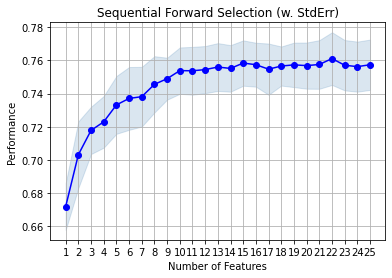

In [14]:
# print chart
fig = plot_sfs(sfs.get_metric_dict(), kind="std_err")
plt.title("Sequential Forward Selection (w. StdErr)")
plt.grid()
plt.show()

In [15]:
results = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
results["avg_score"] = results["avg_score"] * 2 - 1
results

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(7,)","[0.7095238095238096, 0.7142857142857143, 0.647...",0.34381,"(chk_acct_A14,)",0.031383,0.042255,0.014085
2,"(7, 35)","[0.7547619047619046, 0.7121428571428572, 0.658...",0.406381,"(chk_acct_A14, property_A121)",0.044722,0.060214,0.020071
3,"(7, 22, 35)","[0.7607142857142858, 0.7559523809523809, 0.688...",0.435667,"(chk_acct_A14, saving_acct_A65, property_A121)",0.031763,0.042767,0.014256
4,"(6, 7, 22, 35)","[0.7711904761904762, 0.771904761904762, 0.6902...",0.446,"(chk_acct_A13, chk_acct_A14, saving_acct_A65, ...",0.034671,0.046682,0.015561
5,"(6, 7, 22, 35, 41)","[0.793809523809524, 0.7566666666666667, 0.7026...",0.466381,"(chk_acct_A13, chk_acct_A14, saving_acct_A65, ...",0.038801,0.052242,0.017414
6,"(6, 7, 22, 30, 35, 41)","[0.7904761904761906, 0.7823809523809524, 0.742...",0.474238,"(chk_acct_A13, chk_acct_A14, saving_acct_A65, ...",0.042182,0.056794,0.018931
7,"(6, 7, 22, 30, 35, 38, 41)","[0.7816666666666666, 0.7635714285714285, 0.717...",0.476333,"(chk_acct_A13, chk_acct_A14, saving_acct_A65, ...",0.040088,0.053975,0.017992
8,"(1, 6, 7, 22, 30, 35, 38, 41)","[0.7692857142857142, 0.7419047619047618, 0.715...",0.491238,"(age, chk_acct_A13, chk_acct_A14, saving_acct_...",0.037816,0.050916,0.016972
9,"(1, 6, 7, 18, 22, 30, 35, 38, 41)","[0.7752380952380952, 0.7616666666666666, 0.708...",0.498048,"(age, chk_acct_A13, chk_acct_A14, saving_acct_...",0.028149,0.0379,0.012633
10,"(1, 6, 7, 8, 18, 22, 30, 35, 38, 41)","[0.779047619047619, 0.7773809523809524, 0.7173...",0.507762,"(age, chk_acct_A13, chk_acct_A14, purpose_A40,...",0.031155,0.041947,0.013982


In [18]:
final_variables = list(results["feature_names"][15])
final_variables

['present_resid',
 'age',
 'chk_acct_A13',
 'chk_acct_A14',
 'purpose_A40',
 'purpose_A41',
 'saving_acct_A61',
 'saving_acct_A62',
 'saving_acct_A64',
 'saving_acct_A65',
 'sex_A93',
 'property_A121',
 'property_A124',
 'other_install_A143',
 'housing_A151']

In [19]:
dtrain_fin = xgb.DMatrix(X[final_variables], label=y)

### Final fit

In [20]:
MAX_ROUNDS = 1000
CV_SPLITS = 10
EARLY_STOPPING_ROUNDS = 50
SEED = 42

auc_monit = 0.5


def objective(trial, build_name):
    global auc_monit

    param = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-8, 1),
        "max_depth": trial.suggest_int("max_depth", 2, 14),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 50),
        "gamma": trial.suggest_uniform("gamma", 0, 10),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0, 10),
        "subsample": trial.suggest_uniform("subsample", 0.3, 0.9),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.3, 0.9),
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.3, 0.9),
        "colsample_bynode": trial.suggest_uniform("colsample_bynode", 0.3, 0.9),
        "max_delta_step": trial.suggest_int("max_delta_step", 1, 10),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 8)
    }

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-auc")
    xgb_cv_results = xgb.cv(
        params=param,
        dtrain=dtrain_fin,
        stratified=True,
        nfold=CV_SPLITS,
        num_boost_round=MAX_ROUNDS,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose_eval=False,
        seed=SEED,
        callbacks=[pruning_callback],
    )

    n_estimators = len(xgb_cv_results)
    param["n_estimators"] = n_estimators
    trial.set_user_attr("n_estimators", n_estimators)

    mean_train_auc = xgb_cv_results["train-auc-mean"].values[-1]
    mean_val_auc = xgb_cv_results["test-auc-mean"].values[-1]

    if mean_val_auc > auc_monit:
        auc_monit = mean_val_auc

        timestamp = datetime.now().strftime("%H%M%S")
        snapshot_name = f"T{timestamp} {trial.number:01d} [{np.round(mean_train_auc * 2 - 1, 3)} {np.round(mean_val_auc * 2 - 1, 3)}].json"
        json.dump(param, open(os.path.join("Builds", build_name, snapshot_name), "w"))

    return mean_val_auc * 2 - 1


BUILD_NAME = datetime.now().strftime("%Y%m%d_T%H%M%S") + "_German_data_fin"
os.mkdir(os.path.join("Builds", BUILD_NAME))

study = optuna.create_study(directions=["maximize"])

[I 2021-04-26 00:18:18,730] A new study created in memory with name: no-name-2d44b74e-6f54-4128-b48d-0c6456f95b34


In [21]:
TRIALS = None
TIME_OUT = 60 * 2  # minutes
N_JOBS = -1

try:
    study.optimize(
        lambda trial: objective(trial, BUILD_NAME),
        n_trials=TRIALS,
        timeout=TIME_OUT,
        n_jobs=N_JOBS,
    )
except KeyboardInterrupt:
    joblib.dump(study, os.path.join("Builds", BUILD_NAME, "study.pkl"))

joblib.dump(study, os.path.join("Builds", BUILD_NAME, "study.pkl"))

[I 2021-04-26 00:18:21,215] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 0.0012728449267426518, 'max_depth': 14, 'min_child_weight': 22, 'gamma': 9.142398962555296, 'reg_alpha': 8.870668557260938, 'reg_lambda': 5.389929617171042, 'subsample': 0.5182336625719494, 'colsample_bytree': 0.7122352643618524, 'colsample_bylevel': 0.33766173600386407, 'colsample_bynode': 0.7576903708951668, 'max_delta_step': 6, 'scale_pos_weight': 6}. Best is trial 1 with value: 0.0.
[I 2021-04-26 00:18:21,246] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 0.9023502870513389, 'max_depth': 7, 'min_child_weight': 50, 'gamma': 9.453835180954062, 'reg_alpha': 1.5428006119976512, 'reg_lambda': 5.657016004355496, 'subsample': 0.420969145453254, 'colsample_bytree': 0.8791958851953521, 'colsample_bylevel': 0.5906908525294863, 'colsample_bynode': 0.4443212757933548, 'max_delta_step': 7, 'scale_pos_weight': 1}. Best is trial 1 with value: 0.0.
[I 2021-04-26 00:18:22,229] Trial 2

['Builds\\20210426_T001818_German_data_fin\\study.pkl']

In [ ]:
# BUILD_NAME = "20210425_T232957_German_data_fin"
# study = joblib.load(os.path.join("Builds", BUILD_NAME, "study.pkl"))

In [22]:
N = 178
param = study.trials[N].params
param["n_estimators"] = study.trials[N].user_attrs["n_estimators"]

print(study.trials[N].values)
print(param)

[0.5387142]
{'learning_rate': 0.3208371150697334, 'max_depth': 14, 'min_child_weight': 8, 'gamma': 0.7710546555883082, 'reg_alpha': 6.363149955199062, 'reg_lambda': 0.5434369357798852, 'subsample': 0.7830182955045133, 'colsample_bytree': 0.820911303385816, 'colsample_bylevel': 0.7749767494583143, 'colsample_bynode': 0.6886742024787154, 'max_delta_step': 3, 'scale_pos_weight': 3, 'n_estimators': 41}


In [23]:
model = xgb.XGBClassifier(**param, eval_metric="auc")

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
scores = cross_validate(
    model, X[final_variables], np.ravel(y), scoring="roc_auc", cv=cv, return_train_score=True
)

In [24]:
mean_train_auc = scores["train_score"].mean()
mean_test_auc = scores["test_score"].mean()
std_test_auc = scores["test_score"].std()
print("GINI train:", np.round(mean_train_auc * 2 - 1, 3))
print("GINI dev:", np.round(mean_test_auc * 2 - 1, 3), f"({np.round(std_test_auc, 3)})")

GINI train: 0.631
GINI dev: 0.517 (0.046)


In [ ]:
# !jupyter nbconvert --to script --no-prompt MultObject01.ipynb